In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Object masks from prompts with SAM

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt. 

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [1]:
import sys
path = "/home/someone/stage_jonathan/lightning-sam/lightning-sam/l_sam_env/lib/python3.10/site-packages"

if path not in sys.path: sys.path.append(path)

path2 = "/usr/lib/python3/dist-packages"

if path2 not in sys.path: sys.path.append(path2)

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import random as rd
import os

In [3]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([rd.randint(0,255)/255, rd.randint(0,255)/255, rd.randint(0,255)/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25,zorder=10)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25,zorder=10)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [4]:
def get_center_of_mass(mask):
    l_y, l_x = np.where(mask == 1)
    return np.mean(l_x), np.mean(l_y)

def bm0(mask1, mask2):
    mask1 = mask1>0
    mask2 = mask2>0
    mask1_area = np.count_nonzero(mask1==True)      
    mask2_area = np.count_nonzero(mask2==True)
    eps = 1e-8
    intersection = np.count_nonzero( np.logical_and( mask1, mask2) )
    iou = (intersection)/(mask1_area+mask2_area-intersection+eps)
    return iou



def show_anns(anns,annot=None,show=True):
    max_iou=0
    
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    if show:
        ax = plt.gca()
        ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
        if not(annot is None):
            eps = 1e-7

            iou = bm0(annot,m)
            x,y = get_center_of_mass(m)
            if show:
                plt.text(x,y,str(round(iou,4)))
            if iou>max_iou:
                max_iou = iou

        
            
            
    if show:
        ax.imshow(img)
    return max_iou

## Example image

In [8]:
image = cv2.imread('images/truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

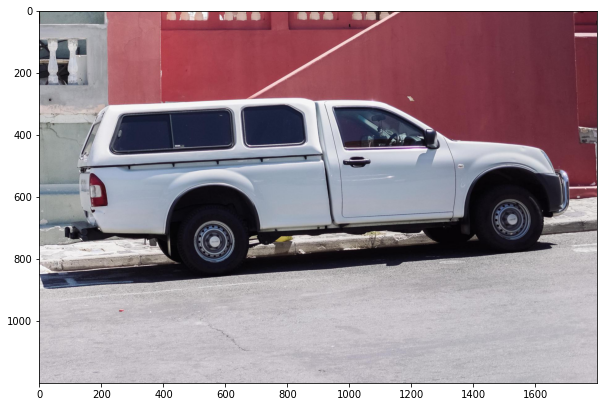

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

## Selecting objects with SAM

First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint. Running on CUDA and using the default model are recommended for best results.

In [6]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

In [10]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
mask_generator = SamAutomaticMaskGenerator(sam)

In [11]:
image.shape

(1200, 1800, 3)

In [12]:
img = cv2.resize(image,dsize=(1800,1800),interpolation = cv2.INTER_CUBIC)

(1800, 1800, 3)


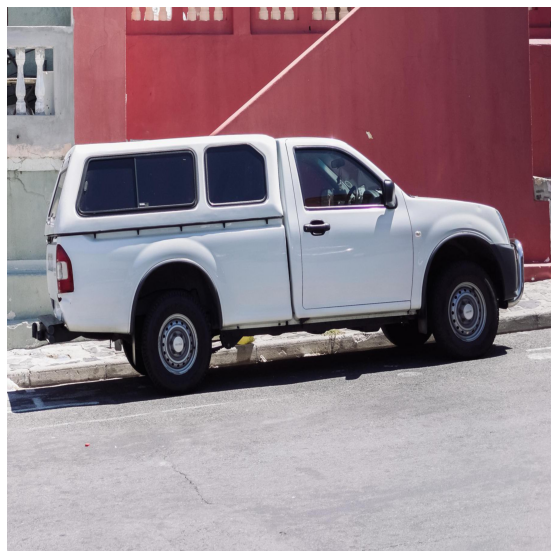

In [13]:
print(img.shape)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis("off")
plt.show()

In [12]:
image = img

In [13]:
area = image.shape[0] * image.shape[1]

9 iter


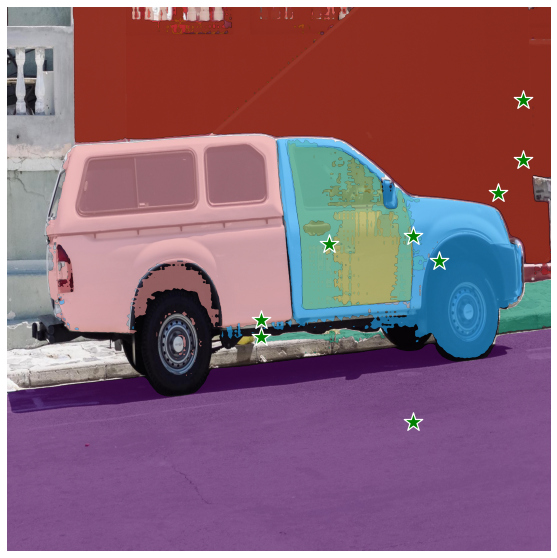

CPU times: user 10 s, sys: 3.67 s, total: 13.7 s
Wall time: 14.2 s


In [15]:
%%time

d = {}

import random as rd

curr_area = area

cr = 28 # "compression rate" 

curr_mask = np.zeros((np.array(image.shape)//cr)[:2])

input_label = np.array([1])

plt.figure(figsize=(10,10))
plt.imshow(image)

i = 0

predictor.set_image(img)
while (curr_mask>1).sum()/np.prod(curr_mask.shape)<0.70 and i<15:
    
    coords = np.where(curr_mask<1)


    choice = rd.choice(np.array(coords).T)
    
    up = np.array([choice*cr])
    
    masks, scores, logits = predictor.predict(
    point_coords=up,
    point_labels=input_label,
    multimask_output=True,
    )
    
    mask = masks[1]
    show_points(up, input_label, plt.gca())
    show_mask(mask, plt.gca())
    
    d[i] = logits
    
    
    
    mask_down = cv2.resize((mask*255).astype("uint8"),dsize=(np.array(image.shape)//cr)[:2][::-1],interpolation=cv2.INTER_CUBIC)
    
    curr_mask += mask_down
    
    curr_mask = np.clip(curr_mask,0,255)
    
    #print(up)
    i+=1
    
    
print(i,"iter")
    


plt.axis('off')
plt.show()  
    



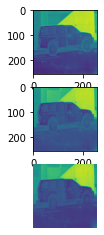

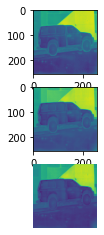

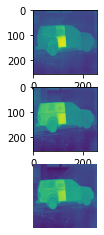

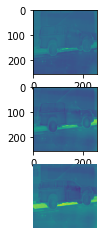

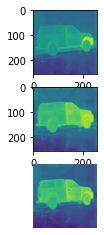

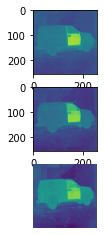

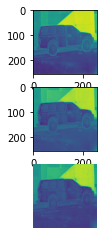

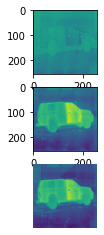

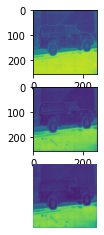

In [16]:
for l_logit in d.values():
    fig, *axes = plt.subplots(3,1)
    for i in range(len(l_logit)):
        axes[0][i].imshow(l_logit[i])
    plt.axis("off")
    plt.show()    

In [61]:
(curr_mask>1).sum()/np.prod(curr_mask.shape)

0.8544921875

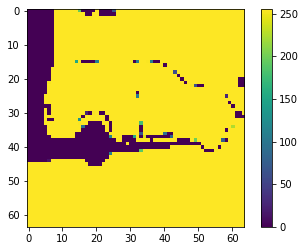

In [18]:
plt.imshow(curr_mask)
plt.colorbar()

## Specifying a specific object with additional points

# Etude des shapes

Etude des shapes à partir 
- d'une dummy image
- d'un batch

(1800, 1800, 3)


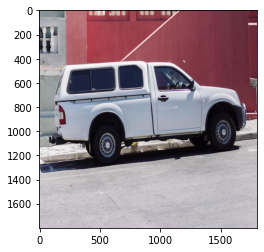

In [19]:
plt.imshow(image)
print(image.shape)
plt.show()

In [20]:
from segment_anything.utils.transforms import ResizeLongestSide

In [21]:
# transform (in set image no torch)

resized = ResizeLongestSide(1024).apply_image(image)


resized.shape

(1024, 1024, 3)

In [22]:
tensor = torch.as_tensor(resized).permute(2, 0, 1).unsqueeze(0) # batch
tensor.shape

torch.Size([1, 3, 1024, 1024])

In [23]:
# pad (in preprocess)

from torch.nn import functional as F

# registered in the buffer
pixel_mean= torch.Tensor([123.675, 116.28, 103.53]).view(-1, 1, 1)
pixel_std = torch.Tensor([58.395, 57.12, 57.375]).view(-1, 1, 1)

print("mean",pixel_mean.shape)


norm = (tensor -  pixel_mean) / pixel_std
print("norm",norm.shape)


h, w = norm.shape[-2:]
padh = 1024 - h
padw = 1024 - w
padded = F.pad(norm, (0, padw, 0, padh))


mean torch.Size([3, 1, 1])
norm torch.Size([1, 3, 1024, 1024])


In [24]:
padded.shape

torch.Size([1, 3, 1024, 1024])

In [25]:
padded = padded.to("cuda")

In [26]:
%%time 
predictor.set_image(image)

CPU times: user 1.13 s, sys: 2.89 ms, total: 1.13 s
Wall time: 1.13 s


In [27]:
predictor.original_size

(1800, 1800)

In [28]:
predictor.features.shape

torch.Size([1, 256, 64, 64])

Padding dégueu

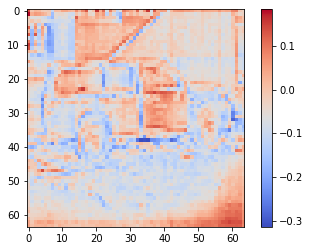

In [29]:

plt.imshow(predictor.features[0][rd.randint(0,255)].cpu().numpy(),cmap="coolwarm")
plt.colorbar()
plt.show()

In [30]:
input_point = np.array([[500,375]])

input_label = np.array([1])

# possible d'inclure plusieurs points

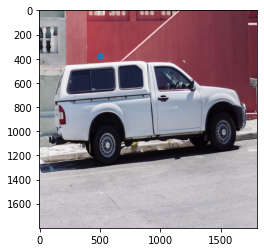

In [31]:
plt.imshow(image)
plt.scatter(input_point[0][0],input_point[0][1])

In [32]:
predictor.transform.apply_coords(input_point,predictor.original_size)

array([[284.44444444, 213.33333333]])

In [33]:
print(500/1800*1024)

print(375/1800*1024.5) # ! padding + centre pixel ???


284.44444444444446
213.4375


# AMG

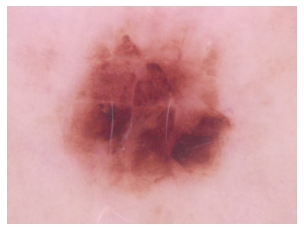

In [5]:
path = "/mnt/data/dataverse_files/HAM10000_val"
L = os.listdir(path)

name = os.path.join(path,L[0])
img = cv2.imread(name)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis("off")
plt.show()

In [6]:
path_ann = "/mnt/data/dataverse_files/HAM10000_segmentations_lesion_tschandl/HAM10000_segmentations_lesion_tschandl"



# ISIC_0032749_segmentation.png

# ISIC_0030216.jpg

idx = 5

name = os.path.join(path,L[idx])
img = cv2.imread(name)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

annot = cv2.imread(os.path.join(path_ann,L[idx].split(".")[0]+"_segmentation.png"))

annot = cv2.cvtColor(annot, cv2.COLOR_BGR2GRAY)

In [7]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [8]:
cpt2 = "/home/someone/stage_jonathan/lightning-sam/lightning-sam/lightning_sam/out/training/mask_decoder20_epochs_HAM10000_train_e8f96573-72a9-4ccb-bd96-8f857a6fa689.pth"

cpt3 = "/home/someone/stage_jonathan/lightning-sam/lightning-sam/lightning_sam/out/training/mask_decoder20_epochs_HAM10000_train_1691017d-e162-4e9b-b102-38f1f9df876e.pth"

cpt4 = "/home/someone/stage_jonathan/lightning-sam/lightning-sam/lightning_sam/out/training/mask_decoder20_epochs_HAM10000_train_2023-07-24_19:56:55.pth"

cpt5 = "/home/someone/stage_jonathan/lightning-sam/lightning-sam/lightning_sam/out/training/mask_decoder10_epochs_HAM10000_train_2023-07-25_16:39:32.pth"

In [9]:
sam.mask_decoder.load_state_dict(torch.load(cpt4))

<All keys matched successfully>

In [10]:
from tqdm import tqdm
n_total = len(L)
print(len(L))

2003


In [11]:
torch.cuda.empty_cache()
del sam
del mask_generator

In [12]:
%%time


sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)

mask_generator = SamAutomaticMaskGenerator(sam,
                                          points_per_side=3,
                                          stability_score_thresh=1e-46,
                                          pred_iou_thresh=1e-2
                                          )

L_iou = []

for idx in tqdm(range(n_total)):
    name = os.path.join(path,L[idx])
    img = cv2.imread(name)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    annot = cv2.imread(os.path.join(path_ann,L[idx].split(".")[0]+"_segmentation.png"))

    annot = cv2.cvtColor(annot, cv2.COLOR_BGR2GRAY)
    
    masks = mask_generator.generate(img)

    """plt.figure(figsize=(4,4))
    plt.imshow(img)"""

    L_iou.append(show_anns(masks,annot,show=False))
    """plt.imshow(annot,alpha=0.1,cmap="hot")

    plt.axis('off')
    plt.title(round(L_iou[-1],3))
    
    
    plt.show() """
L_iou = [iou_ for iou_ in L_iou if iou_!=None and type(iou_)==float]
print(np.mean(np.array(L_iou)))

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 1159/2003 [26:00<18:43,  1.33s/it]/home/someone/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/someone/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2003/2003 [45:17<00:00,  1.36s/it]

0.6369937351962841
CPU times: user 45min 23s, sys: 1min 4s, total: 46min 27s
Wall time: 45min 30s


In [19]:
%%time

sam.mask_decoder.load_state_dict(torch.load(cpt4))

mask_generator = SamAutomaticMaskGenerator(sam,
                                          points_per_side=3,
                                          stability_score_thresh=1e-46,
                                          pred_iou_thresh=1e-2
                                          )

L_iou = []
with tqdm(range(n_total), unit="images") as tepoch:
    for idx in tepoch:
        name = os.path.join(path,L[idx])
        img = cv2.imread(name)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        annot = cv2.imread(os.path.join(path_ann,L[idx].split(".")[0]+"_segmentation.png"))

        annot = cv2.cvtColor(annot, cv2.COLOR_BGR2GRAY)

        masks = mask_generator.generate(img)

        """plt.figure(figsize=(4,4))
        plt.imshow(img)"""
        iou_ = show_anns(masks,annot,show=False)
        if iou_!=None and type(iou_)==float:
            L_iou.append(iou_)
        """plt.imshow(annot,alpha=0.1,cmap="hot")

        plt.axis('off')
        plt.title(round(L_iou[-1],3))


        plt.show() """
        tepoch.set_postfix(m_iou=round(100*np.mean(np.array(L_iou)),5))

    


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2003/2003 [47:30<00:00,  1.42s/images, m_iou=53.2]

CPU times: user 48min 16s, sys: 53.8 s, total: 49min 10s
Wall time: 47min 30s


In [22]:
%%time

sam.mask_decoder.load_state_dict(torch.load(cpt5))

mask_generator = SamAutomaticMaskGenerator(sam,
                                          points_per_side=3,
                                          stability_score_thresh=1e-46,
                                          pred_iou_thresh=1e-2
                                          )

L_iou = []
with tqdm(range(n_total), unit="images") as tepoch:
    for idx in tepoch:
        name = os.path.join(path,L[idx])
        img = cv2.imread(name)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        annot = cv2.imread(os.path.join(path_ann,L[idx].split(".")[0]+"_segmentation.png"))

        annot = cv2.cvtColor(annot, cv2.COLOR_BGR2GRAY)

        masks = mask_generator.generate(img)

        """plt.figure(figsize=(4,4))
        plt.imshow(img)"""
        iou_ = show_anns(masks,annot,show=False)
        if iou_!=None and type(iou_)==float:
            L_iou.append(iou_)
        """plt.imshow(annot,alpha=0.1,cmap="hot")

        plt.axis('off')
        plt.title(round(L_iou[-1],3))


        plt.show() """
        tepoch.set_postfix(m_iou=round(100*np.mean(np.array(L_iou)),5))
print(np.mean(np.array(L_iou)))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2003/2003 [48:43<00:00,  1.46s/images, m_iou=49.9]

0.499273676244088
CPU times: user 49min 29s, sys: 55 s, total: 50min 24s
Wall time: 48min 43s


Results (validation set = 2003 images)
- Finetuned model v1 (2 modules unfrozen) : 53.2
- Finetuned model v2 (3 modules unfrozen) : 49.9
- Baseline : **63.6**